Monitoring
===
This script produce time plots of temperature, humidity, trigger rate and accidental rate. Information taken from the parsing dictionary that reads the SLOWCONTROL file.

**Minimal requirement: Run parsing step**

To remove this requirements, it is necessary to read directly from the SLOWCONTROL file.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from muraves_lib import run_manager
from muraves_lib import file_handler
from datetime import datetime

# Function to search for json from parsing to have info about good and bad runs
import json


def is_good_run(root_path, range_run, color, parsing_version = 'v0') :
    file = []
    is_good = []

    for (run, col) in zip(range_run, color):
        try:
            with open(f'{root_path}/PARSED/{col}/{parsing_version}/ADC_run{run}.json', "r", encoding="utf-8") as f:
                data = json.load(f)
                is_good.append(True if data.get("status")== "ok" else False)
                file.append(f"found" if len(data.get("subruns"))!= 0 else "not found")
        except FileNotFoundError:
            file.append("not found")
            is_good.append(False)
        
    return file, is_good

def time_plot(var, time, **kwargs):
    ref = kwargs.get('ref', None)
    xaxis = kwargs.get('xaxis', None)
    yaxis = kwargs.get('yaxis', None)
    title = kwargs.get('title', None)
    status = kwargs.get('status', None)   # ← NEW

    # Main plot
    fig = plt.figure(figsize=(20,10))
    ax_main = fig.add_axes([0.2, 0.2, 0.6, 0.6])  # left, bottom, width, height


    # --- BACKGROUND COLORING (NEW) ---
    #if status is not None:
    #    for x, s in zip(time, status):
    #        if s is True:
    #            ax_main.axvspan(x - 0.5, x + 0.5, color="green", alpha=0.2)
    #        elif s is False:
    #            ax_main.axvspan(x - 0.5, x + 0.5, color="red", alpha=0.2)
    #        # "unknown" → no background
    # --------------------------------
    # Tracciare le barre
    if status is not None:
        colors = []
        for s in status:
            if s == True:
                colors.append("green")
            elif s == False:
                colors.append("red")
            else:
                colors.append("white")  # colore per "unknown"
        #colors = ["green" if s else "red" for s in status]
        ax_main.bar(time, var, color=colors, width=0.8, alpha=0.3)

    ax_main.plot(time, var, marker='.')
    if ref is not None:
        ax_main.plot(time,ref, marker='',  color='gray', linestyle='--')


    ax_main.set_xlabel(xaxis['label']) if xaxis else  ax_main.set_xlabel("Time")
    ax_main.set_ylabel(yaxis['label']) if yaxis else ax_main.set_ylabel("a.u.")
    ax_main.set_ylim(yaxis['range']) if yaxis and 'range' in yaxis else None
        

    if title: plt.title(title)
    fig.autofmt_xdate()   # rotate date labels
    ax_main.grid(True)
    plt.show()




def run_plots(
    run_range: list,
    dataframe: pd.DataFrame,
    raw_files_path: str,
    is_good = False,
    temperature=True,
    humidity=True,
    trigger_rate=True,
    accidental_rate=True

    
):


    dataframe = dataframe.query(f'run >= {run_range[0]} & run < {run_range[-1]+1}')
    dataframe = dataframe.sort_values(by='run')
    if is_good:
        file, is_good = is_good_run(
                        root_path=raw_files_path,
                        range_run=run_range,
                        color=dataframe["hodoscope"]
            )
        dataframe["is_good"] = [ ig if f == "found" else "unknown" for f, ig in zip(file, is_good)]
    else:
        dataframe["is_good"] = ["unknown"] * len(dataframe)

    #for run in run_range:
    #    runs.append(run)
        
        #info = file_handler.read_run_info_from_json(
        #   parsed_files_path + f'ADC_run{run}.json'
        #)
        #info_list.append(info)

    trs          = dataframe["trigger_rate"].tolist() #extract_var("trigger_rate", info_list)
    ars          = dataframe["accidental_rate"].tolist() #extract_var("accidental_rate", info_list)
    #times        = dataframe["timestamp_new"]
    times        = extract_time(list(dataframe["timestamp"]))
    temperatures = dataframe["temperature"].tolist() #extract_var("temperature", info_list)
    wps          = dataframe["wp"].tolist() #extract_var("working_point", info_list)

    #---- filling missing runs ---
    for run in run_range:
        if run not in dataframe["run"].to_list():
            trs.insert(run - run_range[0], np.nan)
            ars.insert(run - run_range[0], np.nan)
            temperatures.insert(run - run_range[0], np.nan)
            wps.insert(run - run_range[0], np.nan)
            times.insert(run - run_range[0], np.nan)

    if trigger_rate:
        time_plot(np.array(trs), np.array(run_range),
                        xaxis={'label': 'Run'},
                        yaxis={'label': 'Trigger Rate', 'range': (0, 30)},
                        status=dataframe["is_good"].tolist() # ← NEW
                        )

    if accidental_rate:
        time_plot(np.array(ars), np.array(times),
                        xaxis={'label': 'Run'},
                        yaxis={'label': 'Accidental Rate'},
                        status=dataframe["is_good"].tolist()
                        )

    if temperature:
        time_plot(np.array(temperatures), np.array(times),
                        ref=np.array(wps),
                        xaxis={'label': 'Time'},
                        yaxis={'label': 'Temperature (°C)', 'range': (10, 30)},
                        status=dataframe["is_good"].tolist()
                        )
        


def extract_time_old(ts_list) -> list:
    """
    Given a list of run dictionaries, return a of times (human readable format):
    - times (datetime objects rounded to hours)
    - temperatures
    """

    times = []
    day = None



    for ts in ts_list:
        # convert milliseconds → seconds → datetime
        try:
            dt = datetime.fromtimestamp(ts / 1000.0)
            # round down to hour (drop minutes/seconds)
            dt_hour = dt.replace(second=0, microsecond=0)
            #converted_time = dt_hour.strftime("%Y-%m-%d %H:%M")
            #print("day", day)
            #print(converted_time.split(" ")[0])
            if day == dt_hour.strftime("%Y-%m-%d"):
                times.append(dt_hour.strftime("%H:%M"))
            else:
                day = dt_hour.strftime("%Y-%m-%d")
                times.append(dt_hour.strftime("%Y-%m-%d %H:%M"))

        except:
            times.append(None)
        

    return times

#def extract_var(var, data_list) -> list:
#    var_list =[]
#    for data in data_list:
#        value = data.get(var)
#
#        var_list.append(float(value))
#    
#    return var_list


def extract_time(ts_list) -> list:
    """
    Given a list of timestamps in milliseconds, return a list of times in
    human-readable format (rounded down to minutes, no duplicates).
    """

    times = []

    for ts in ts_list:
        try:
            # convert milliseconds → seconds → datetime
            dt = datetime.fromtimestamp(ts / 1000.0)
            # round down to minutes (arrotondare all'ora o minuto a scelta)
            dt_minute = dt.replace(second=0, microsecond=0)
            # convert to string
            time_str = dt_minute.strftime("%Y-%m-%d %H:%M")
            times.append(time_str)
        except Exception:
            times.append(None)

    # rimuove eventuali duplicati pur mantenendo l'ordine
    times = list(dict.fromkeys(times))

    return times

In [ ]:
#create db

#run_range = range(2500,2510,1)
temperature     = True
humidity        = False
trigger_rate    = True
accidental_rate = True

raw_files_path = '/data/RAW_GZ'
hodoscope_color = 'NERO'



dataframe = run_manager.create_database(raw_files_path, color_list=[hodoscope_color])
print(dataframe.head())


In [2]:
# open database
import pickle
with open('/workspace/Software/data_scan.pkl', 'rb') as f:
    df = pickle.load(f)

print(len(df))

12059


In [3]:
run_range = range(2500,2510,1)
temperature     = True
humidity        = False
trigger_rate    = True
accidental_rate = False
hodoscope_color = "NERO"
status_path = "/outputs/tmp/"

In [4]:


dataframe = df.query(f'hodoscope=="{hodoscope_color}" and run >= {run_range[0]} and run < {run_range[-1]+1}')
print(len(dataframe))

for run in run_range:
    if run not in dataframe["run"].to_list():
        print("missing run:", run)

10


/tmp/ipykernel_348542/808535656.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["timestamp_new"] = pd.to_datetime(dataframe["timestamp"])


10


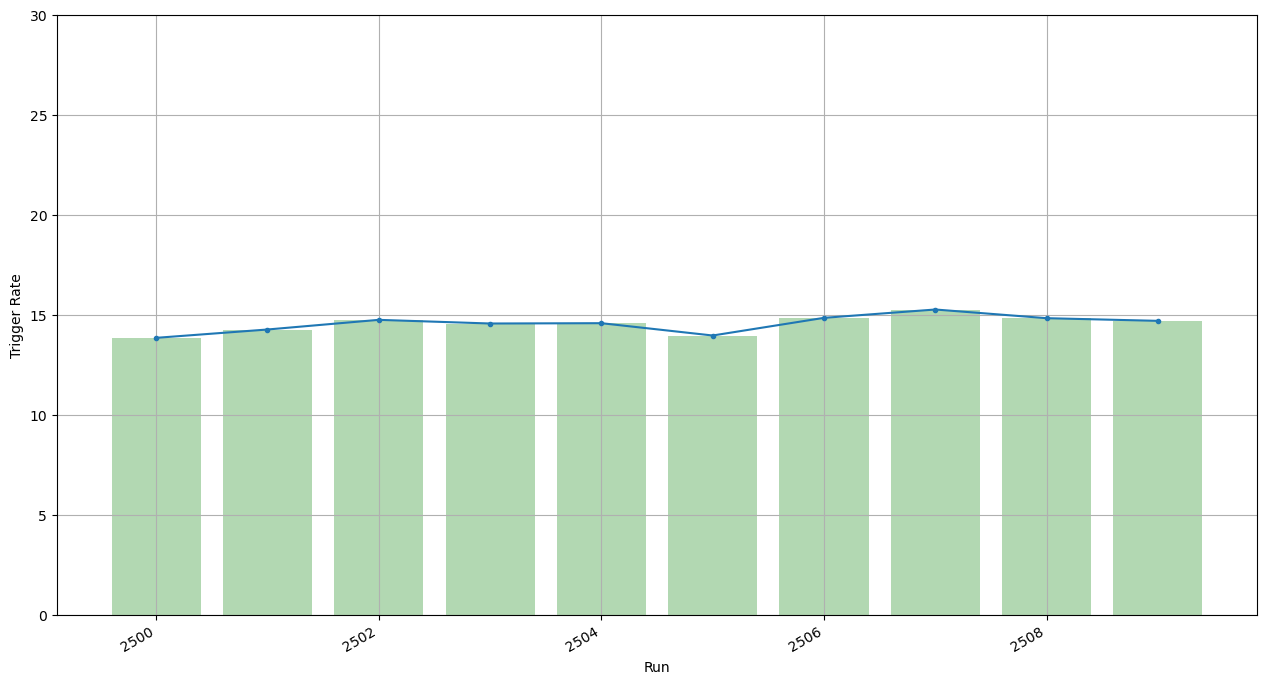

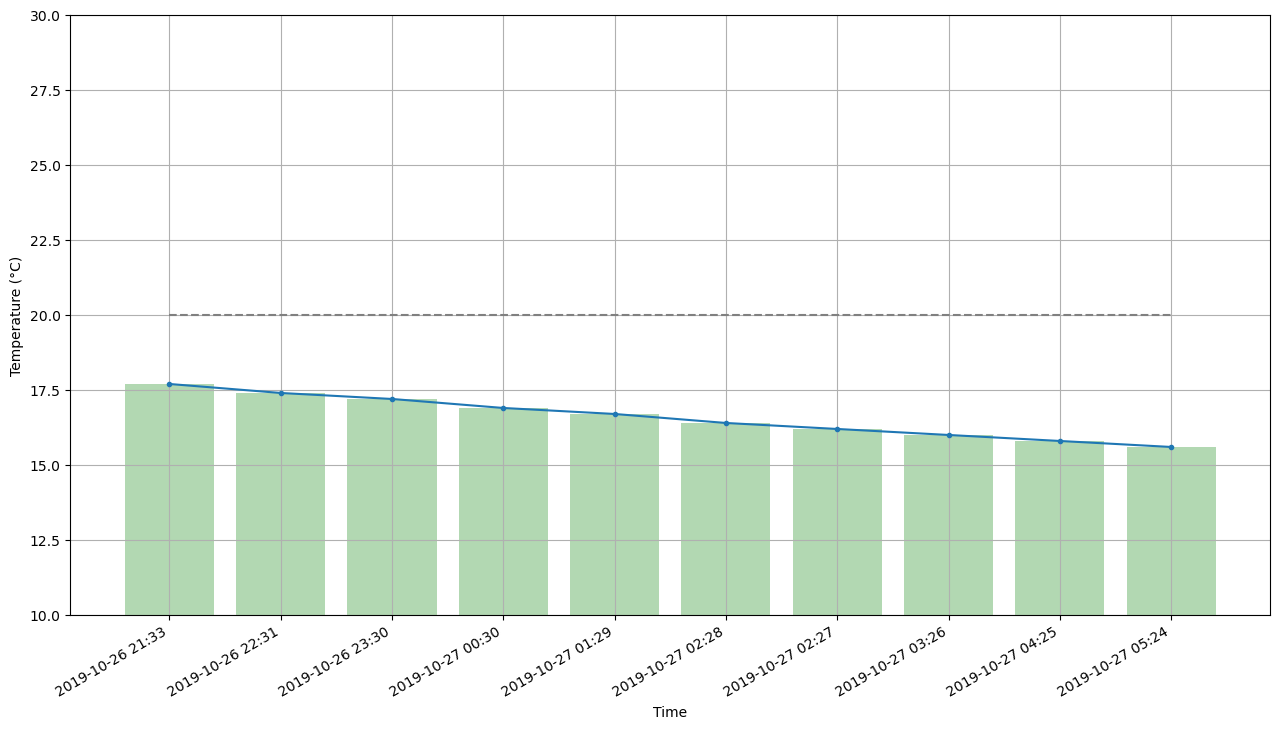

In [5]:

dataframe["timestamp_new"] = pd.to_datetime(dataframe["timestamp"])
dataframe = dataframe.sort_values("timestamp_new")
dataframe = dataframe.drop_duplicates(subset=["timestamp_new"])
print(len(dataframe))
run_plots(run_range, dataframe, temperature=temperature, humidity=humidity, trigger_rate=trigger_rate, accidental_rate=accidental_rate, is_good= True, raw_files_path=status_path)

In [51]:
def is_good_run(root_path, range_run, color, parsing_version = 'v0') :
    file = []
    is_good = []

    for (run, col) in zip(range_run, color):
        print(run)
        try:
            with open(f'{root_path}/PARSED/{col}/{parsing_version}/ADC_run{run}.json', "r", encoding="utf-8") as f:
                data = json.load(f)
                is_good.append(True if data.get("status")== "ok" else False)
                file.append(f"found" if len(data.get("subruns"))!= 0 else "not found")
        except FileNotFoundError:
            file.append("not found")
            is_good.append(False)
        
        
        print("Reading file:", f'{root_path}/PARSED/{col}/{parsing_version}/ADC_run{run}.json')
        print("Debug is_good_run:", file, is_good)
    return file, is_good

print(is_good_run(status_path, run_range, dataframe["hodoscope"]))

2525
Reading file: /outputs/tmp//PARSED/NERO/v0/ADC_run2525.json
Debug is_good_run: ['found'] [True]
2526
Reading file: /outputs/tmp//PARSED/NERO/v0/ADC_run2526.json
Debug is_good_run: ['found', 'found'] [True, True]
2527
Reading file: /outputs/tmp//PARSED/NERO/v0/ADC_run2527.json
Debug is_good_run: ['found', 'found', 'found'] [True, True, True]
2528
Reading file: /outputs/tmp//PARSED/NERO/v0/ADC_run2528.json
Debug is_good_run: ['found', 'found', 'found', 'found'] [True, True, True, True]
2529
Reading file: /outputs/tmp//PARSED/NERO/v0/ADC_run2529.json
Debug is_good_run: ['found', 'found', 'found', 'found', 'not found'] [True, True, True, True, False]
2530
Reading file: /outputs/tmp//PARSED/NERO/v0/ADC_run2530.json
Debug is_good_run: ['found', 'found', 'found', 'found', 'not found', 'not found'] [True, True, True, True, False, False]
2531
Reading file: /outputs/tmp//PARSED/NERO/v0/ADC_run2531.json
Debug is_good_run: ['found', 'found', 'found', 'found', 'not found', 'not found', 'not fo